In [76]:
%load_ext autoreload
%autoreload 2
import torch
from stylegan2 import Generator                            # StyleGAN model
from stylegan2_output import GANOutputs              # Data structure to hold GAN outputs
import ptutils                                      # Helper tensor functions
import visutils                                     # Visualization functions
from style2_interpolator import StyleInterpolator    # The 'sequential' style-interpolator (Eq. 5)
import cielab  
from tqdm import tqdm
from spherical_kmeans import MiniBatchSphericalKMeans
from matplotlib import pyplot as plt 
import numpy as np 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from factor_catalog import FactorCatalog

In [9]:
torch.cuda.set_device(2)

In [10]:
dataset_name = 'ffhq'
config = 'E'
channel = 1 if config == 'E' else 2
root_dir = '../karras_ckpt' # See comment above regarding additional files
if dataset_name == 'cat':
    truncation = 0.5
    size = 256
elif dataset_name == 'ffhq':
    truncation = 0.7
    size = 1024



In [11]:
G = Generator(size, 512, 8, channel_multiplier=channel)
G.load_state_dict(torch.load('{}/{}{}.pt'.format(root_dir, dataset_name, config))['g_ema'])
G.eval()
G = G.cuda()

In [73]:
N = 200 
batch_size = 4 
n_batch = N // batch_size
batch_sizes = [batch_size]*n_batch
features = []
images = []

with torch.no_grad():
    for batch in tqdm(batch_sizes):
        z = torch.randn(batch, 512).cuda()
        image, ys, extract_feat = G(z, return_latents=True)
        features.append(extract_feat.to('cpu'))
        images.append(image)

100%|██████████| 50/50 [00:06<00:00,  7.73it/s]


In [74]:
features = torch.cat(features, 0)
features.size()

torch.Size([200, 512, 32, 32])

In [79]:
images = torch.cat(images, 0)
images = (images.clamp(-1, 1) + 1) / 2
images = images.cpu()
images = ptutils.MultiResolutionStore(images)

In [80]:
K = 20
catalog = FactorCatalog(K, random_state=10, batch_size=100, 
                            compute_labels=True, init='k-means++', 
                            init_size=None, max_iter=100, max_no_improvement=10, 
                            n_init=3, reassignment_ratio=0.01, tol=0.0, verbose=0)
# old_catalog.annotations = {
#  'eyes': [12],
#  'nose': [13],
#  'neck': [9],
#  'mouth': [7],
#  'forehead': [6],
#  'chin': [5],
#  'cheeks': [3],
#  'hair': [19, 16, 14, 10, 1]}
for i in range(K): 
    catalog.annotations[str(i)] = [i]

In [81]:
heatmaps, labels = catalog.fit_predict(features)

torch.Size([204800, 512])


In [82]:
print(heatmaps._data[32].size())

torch.Size([200, 20, 32, 32])


torch.Size([200, 20, 32, 32])


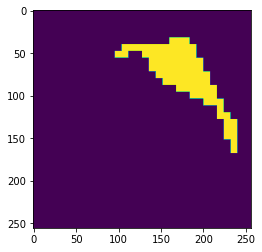

/tmp/cache/python/lib/python3.6/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

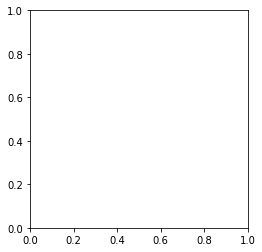

In [83]:
res = 256
print(heatmaps._data[32].size())
for i in range(K):
    plt.imshow(heatmaps.get(res)[0][i])
    plt.show()
    plt.imshow(images.get(res)[0][i])
    plt.show()
# visutils.show(heatmaps.get(res)[0].permute(0,2,3,1))#, {k: v.rgb.get(res) for k,v in part_gs.items()});